In [9]:
%matplotlib ipympl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
import sys
import pywt
import util

# interactive plotting with %matplotlib notebook

!ls ../../recordings

2025-03-21_16-10_gain24_boardAds1299_vref4.5.csv
2025-04-08_17-38_gain24_boardAds1299_vref4.5.csv
8ch.csv
basic.ipynb
battery.csv
ds004504
ds006036
march-25-test.csv
openneuro-dementia.ipynb
openneuro_all_groups_psd_resid_tsne_plot.png
rand-test.csv


In [18]:
print('Load data and get properties\n')

# fname = '8ch.csv'
fname = '2025-04-08_17-38_gain24_boardAds1299_vref4.5.csv'
df = pd.read_csv(f"../../recordings/{fname}")
fname = '2025-04-08_17-38_gain24_boardAds1299_vref4.5.csv'

board, gain, Fs, vref, avss, resolution, vmid = util.get_board_attributes(fname)
channel_count = len([i for i in list(df.columns) if i.find('_raw_sample') !=-1])
len_minutes = (df['timestamp'].iloc[-1]-df['timestamp'].iloc[0])/1000000. / 60.

print(f"vref={vref}V, avss={avss}V, gain={gain}, sample_rate={Fs}hz, vmid={vmid}, resolution={resolution} bit")
print(f"\nchannel count= {channel_count}")
print(f"\ndata length= {int(len_minutes)}min {int((len_minutes%1)*60)}sec")

Load data and get properties

vref=4.5V, avss=0V, gain=24.0, sample_rate=250.0hz, vmid=2.25, resolution=24 bit

channel count= 4

data length= 0min 29sec


In [15]:
df = util.add_time_and_raw_voltage_columns(df, fname)

# Trime first and last
remove_first_seconds = 40
remove_last_seconds = 8
max_time = df['time_sec'].max()
df = df[(df['time_sec'] >= remove_first_seconds) & (df['time_sec'] <= (max_time - remove_last_seconds))].reset_index(drop=True)

df

added these new columns, ['time_sec', 'ch1_raw_voltage', 'ch2_raw_voltage', 'ch3_raw_voltage', 'ch4_raw_voltage']


,timestamp,ch1_voltage,ch2_voltage,ch3_voltage,ch4_voltage,ch1_raw_sample,ch2_raw_sample,ch3_raw_sample,ch4_raw_sample,time_sec,ch1_raw_voltage,ch2_raw_voltage,ch3_raw_voltage,ch4_raw_voltage


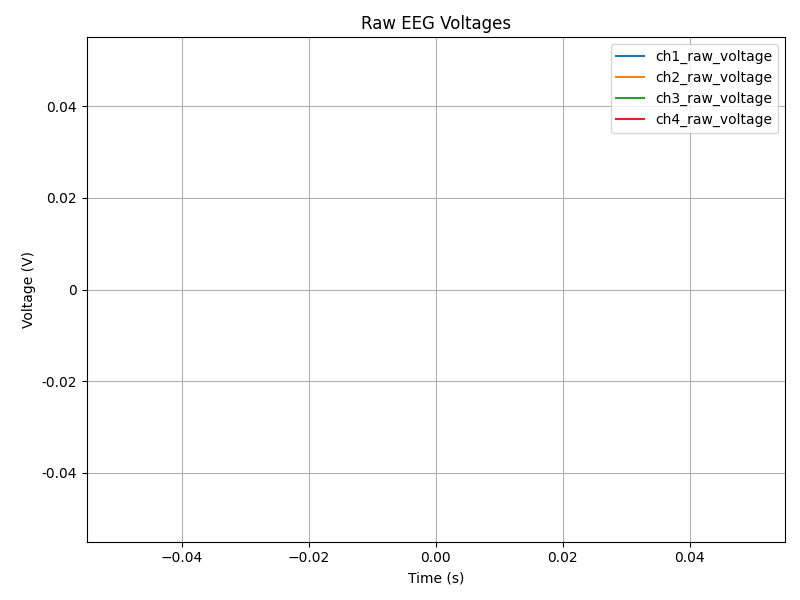

In [16]:
# time = df['time_sec'][df['time_sec'] >= 0]
raw_voltage_cols = util.get_raw_volt_cols(df)

# channels = ['ch1_raw_voltage', 'ch2_raw_voltage', 'ch3_raw_voltage', 'ch4_raw_voltage']
util.plot_raw_voltages(df, raw_voltage_cols)

ValueError: The length of the input vector x must be greater than padlen, which is 27.

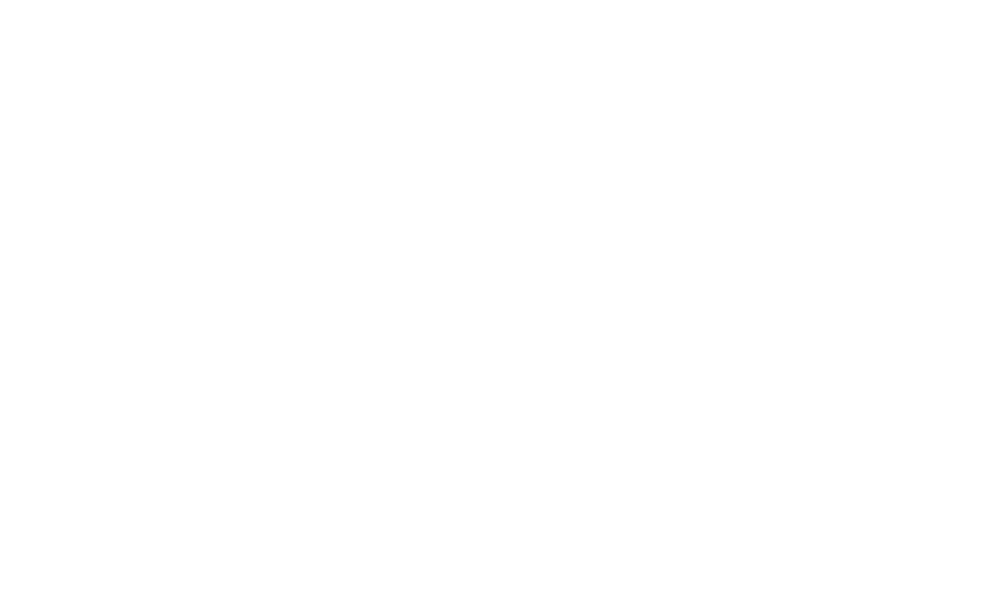

In [17]:
# time = df['time_sec'][df['time_sec'] >= 0]
raw_voltage_cols = util.get_raw_volt_cols(df)

# channels = ['ch1_raw_voltage', 'ch2_raw_voltage', 'ch3_raw_voltage', 'ch4_raw_voltage']
util.plot_power_spectrum_welch(df, raw_voltage_cols, Fs, 2, 80, 4, 125)
_ = util.plot_spectrogram(df['ch1_raw_voltage'], Fs, 70)

/opt/homebrew/lib/python3.13/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


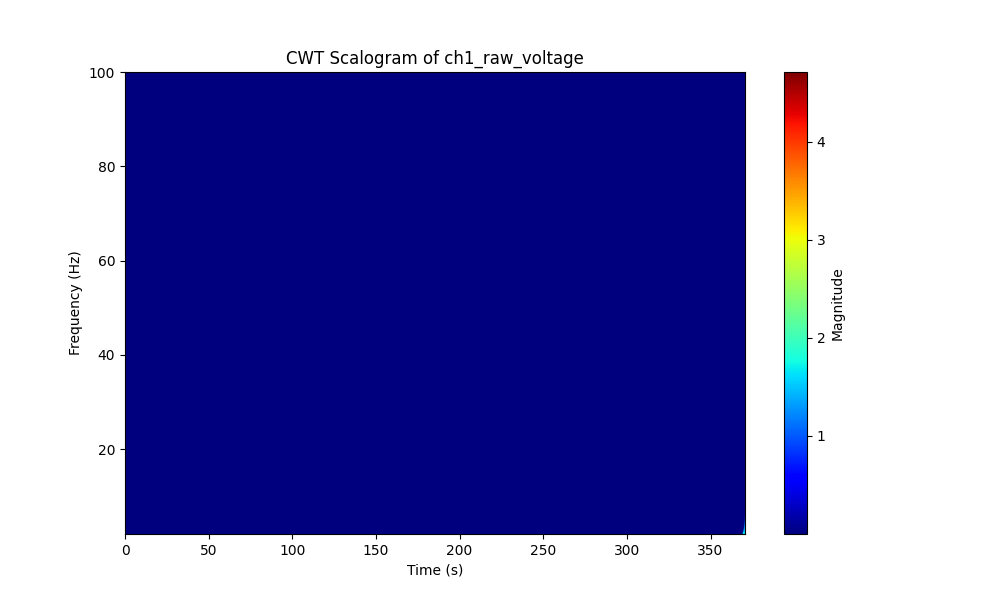

In [ ]:
_ = util.plot_cwt(df['ch1_raw_voltage'], Fs, 2, 100, 196)